In [1]:
# 导入必要的库
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 读取过期用户的数据
df_outdated = pd.read_csv('outdated.csv')

In [3]:
df_outdated.head(5)

,订单号,用户id,建单日期,商品id,商品名称,金额
0,2.016060e+14,23962,2016/6/16,2,会员包年,300.0
1,2.016050e+14,39192,2016/5/17,2,会员包年,300.0
2,2.016050e+14,35495,2016/5/18,2,会员包年,300.0
3,2.016050e+14,39366,2016/5/18,2,会员包年,300.0
4,2.016050e+14,39426,2016/5/18,2,会员包年,300.0


In [4]:
df_outdated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49374 entries, 0 to 49373
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   订单号     49374 non-null  float64
 1   用户id    49374 non-null  int64  
 2   建单日期    49374 non-null  object 
 3   商品id    49374 non-null  int64  
 4   商品名称    49374 non-null  object 
 5   金额      49374 non-null  float64
dtypes: float64(2), int64(2), object(2)
memory usage: 2.3+ MB


In [5]:
# 转换‘建单日期’为日期格式
df_outdated['建单日期'] = pd.to_datetime(df_outdated['建单日期'])

# 计算最大日期作为“今天”的日期
current_date = df_outdated['建单日期'].max() + pd.to_timedelta(1, 'D')

In [6]:
# 计算每个用户的 Recency、Frequency 和 Monetary 值

rfm = df_outdated.groupby('用户id').agg({
    '建单日期': lambda x: (current_date - x.max()).days, # Recency
    '订单号': 'count',  # Frequency
    '金额': 'sum'
}).rename(columns={
    '建单日期': 'Recency',
    '订单号': 'Frequency',
    '金额': 'Monetary'
})

In [7]:
rfm.head(5)

,Recency,Frequency,Monetary
用户id,,,
1,709,1,301.0
3,1022,2,600.0
5,2370,1,300.0
7,1556,1,300.0
8,2242,1,300.0


In [8]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31761 entries, 1 to 731132
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    31761 non-null  int64  
 1   Frequency  31761 non-null  int64  
 2   Monetary   31761 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 992.5 KB


In [9]:
# 先用hdbscan进行聚类

import hdbscan
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
import seaborn as sns

In [10]:
# 数据预处理
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# 使用优化的参数进行聚类
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=80,
    min_samples=2, 
    metric='manhattan', 
    cluster_selection_epsilon=0.2, 
    alpha=1.5, 
    cluster_selection_method='eom', 
    algorithm='best')
clusterer.fit(rfm_scaled)
rfm['Cluster'] = pd.Series(clusterer.labels_, index=rfm.index)

# 查看结果
print(rfm['Cluster'].value_counts())

 6     12552
 5      8891
 10     3356
 2      2484
 9      2285
 7       646
 8       569
 4       309
 3       201
 0       200
-1       166
 1       102
Name: Cluster, dtype: int64


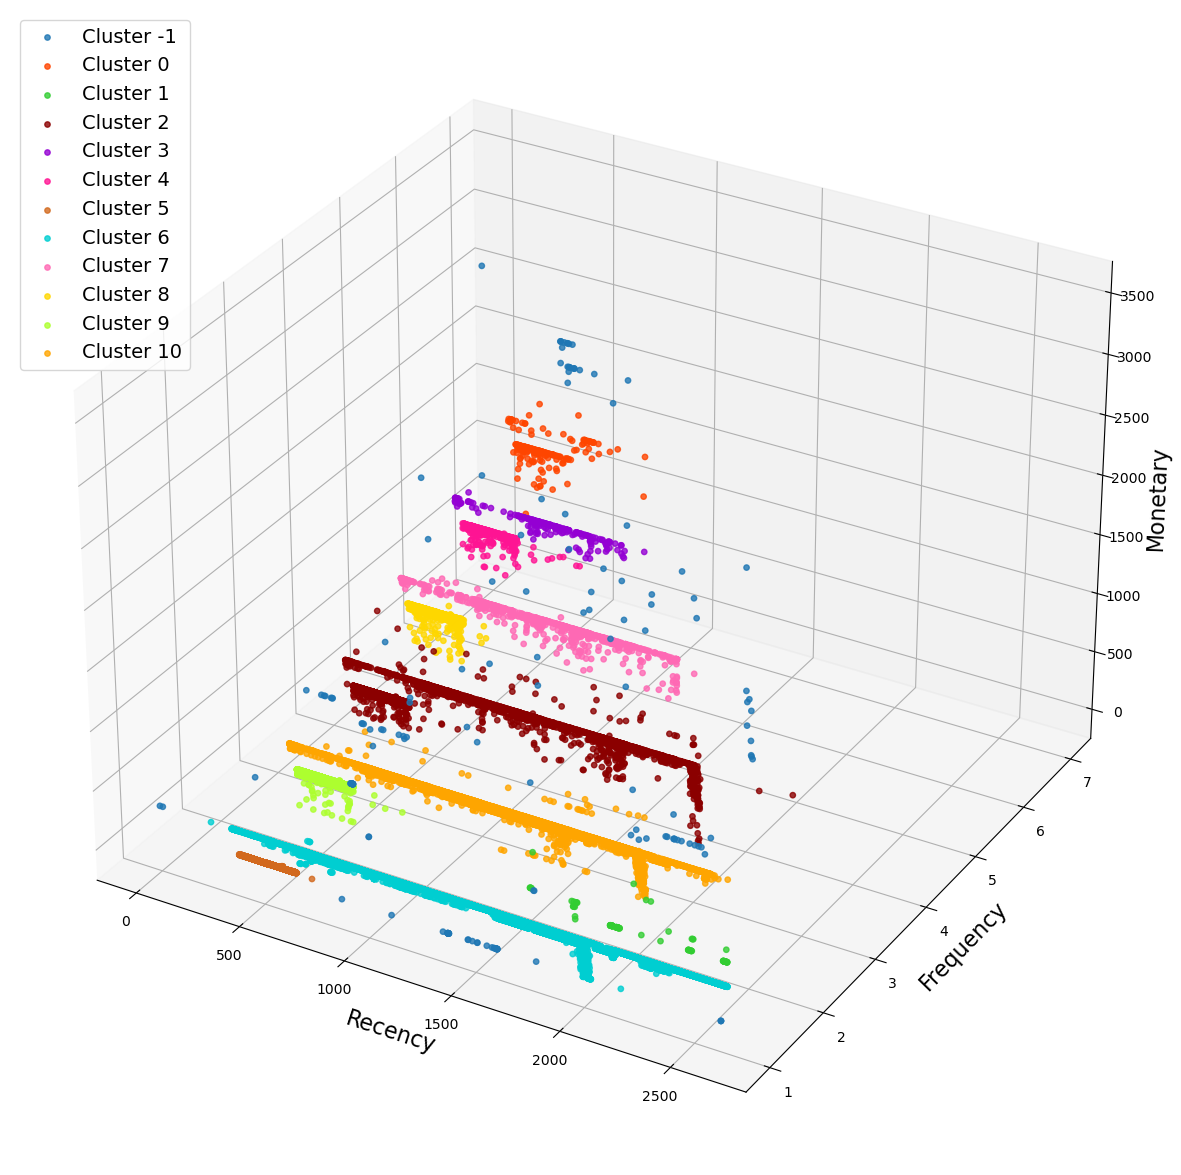

In [12]:

# 使用更为鲜明的颜色组合
colors = [
    "#1f77b4", "#ff4500", "#32cd32", "#8b0000", "#9400d3",
    "#ff1493", "#d2691e", "#00ced1", "#ff69b4", "#ffd700",
    "#adff2f", "#ffa500", "#4b0082"
]

# 进一步增加透明度
alpha_value = 0.8

# 保持点的大小
sizes = {cluster: 15 for cluster in rfm['Cluster'].unique()}

fig = plt.figure(figsize=(20, 15))
dx = fig.add_subplot(111, projection='3d')

for i, label in enumerate(sorted(rfm['Cluster'].unique())):
    dx.scatter(rfm[rfm.Cluster == label].Recency,
               rfm[rfm.Cluster == label].Frequency,
               rfm[rfm.Cluster == label].Monetary,
               c=[colors[i]],
               label='Cluster ' + str(label),
               s=sizes[label], alpha=alpha_value)

dx.set_xlabel('Recency', fontsize=16)
dx.set_ylabel('Frequency', fontsize=16)
dx.set_zlabel('Monetary', fontsize=16)
dx.legend(fontsize=14, loc='upper left')
dx.grid(True)  # 保持网格
plt.show()

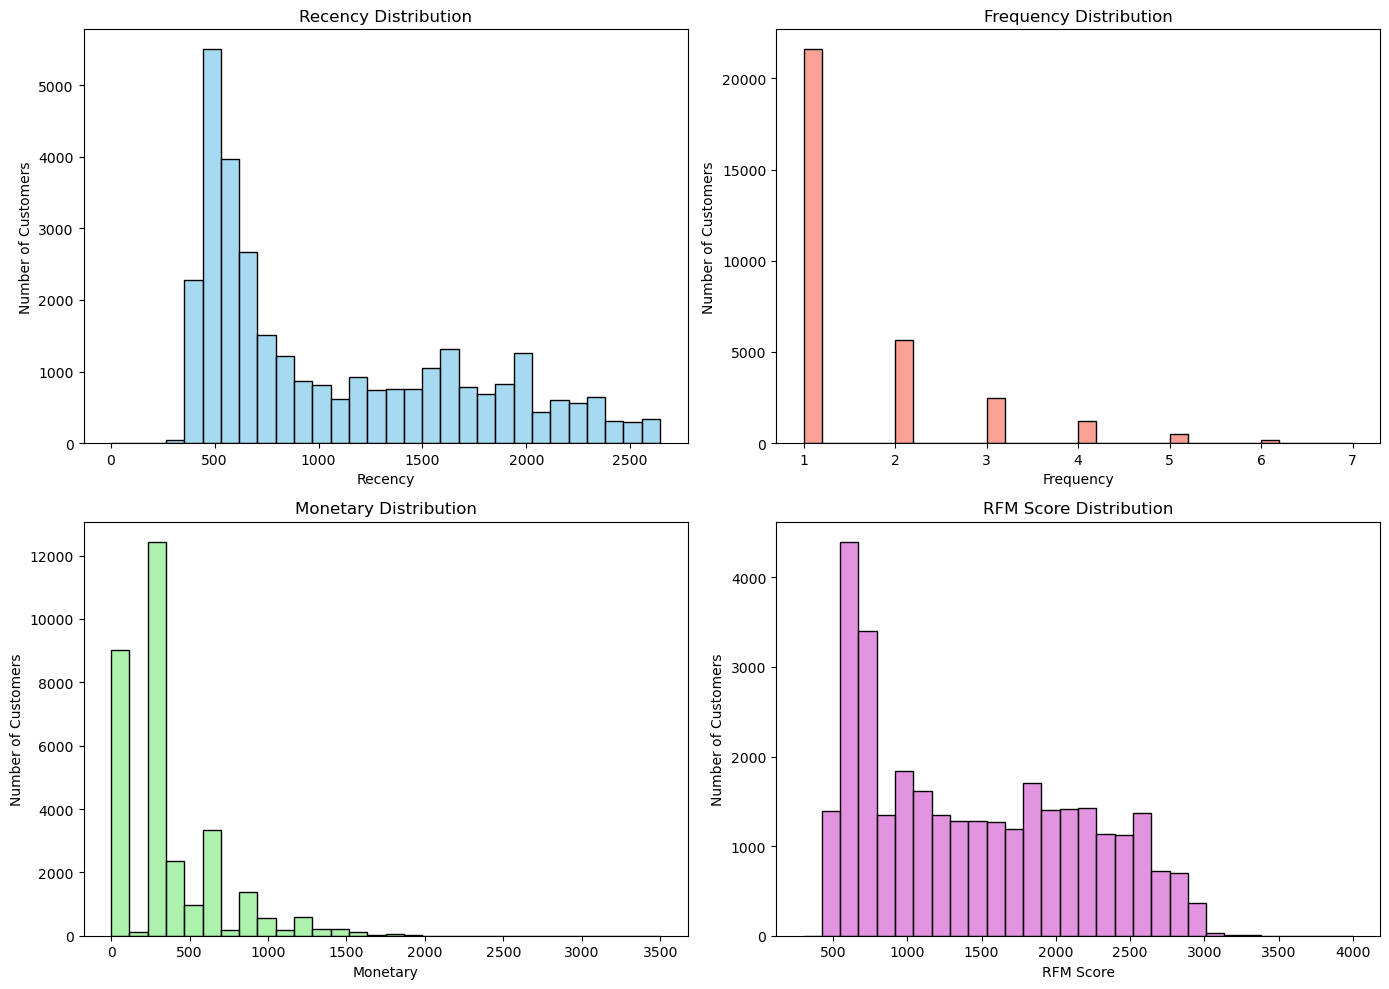

In [20]:
# 创建图形
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Recency分布图
sns.histplot(rfm['Recency'], kde=False, ax=ax[0, 0], bins=30, color='skyblue')
ax[0, 0].set_title('Recency Distribution')
ax[0, 0].set_xlabel('Recency')
ax[0, 0].set_ylabel('Number of Customers')

# Frequency分布图
sns.histplot(rfm['Frequency'], kde=False, ax=ax[0, 1], bins=30, color='salmon')
ax[0, 1].set_title('Frequency Distribution')
ax[0, 1].set_xlabel('Frequency')
ax[0, 1].set_ylabel('Number of Customers')

# Monetary分布图
sns.histplot(rfm['Monetary'], kde=False, ax=ax[1, 0], bins=30, color='lightgreen')
ax[1, 0].set_title('Monetary Distribution')
ax[1, 0].set_xlabel('Monetary')
ax[1, 0].set_ylabel('Number of Customers')

# RFM得分分布图 (需要计算RFM得分)
rfm['RFM_Score'] = rfm['Recency'] + rfm['Frequency'] + rfm['Monetary']
sns.histplot(rfm['RFM_Score'], kde=False, ax=ax[1, 1], bins=30, color='orchid')
ax[1, 1].set_title('RFM Score Distribution')
ax[1, 1].set_xlabel('RFM Score')
ax[1, 1].set_ylabel('Number of Customers')

plt.tight_layout()
plt.show()